Model from paper:  
https://github.com/janZub-AI/EmotionDetectionVGG



Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git lfs install
!git clone https://github.com/WiktorPieklik/Facial-Expression-Recognition.git
!cd /content/Facial-Expression-Recognition && git checkout custom-net

In [ ]:
!python /content/Facial-Expression-Recognition/install.py

In [ ]:
!cd /content/Facial-Expression-Recognition && python /content/Facial-Expression-Recognition/setup_dataset.py

In [ ]:
!cd /content/Facial-Expression-Recognition/
from src.preprocessing import BalancedAugmenter


In [ ]:

# import cv2
# import imgaug.augmenters as iaa
# import os
# from random import sample
# from typing import List, Dict

# import numpy as np


# def save_images(dataset_path: str, augmented_images: Dict[str, List[np.ndarray]]) -> None:
#     counter = 1
#     for emotion, imgs in augmented_images.items():
#         for img in imgs:
#             path = f"{dataset_path}/{emotion}/aug_{counter:04d}.jpg"
#             cv2.imwrite(path, img)
#             counter += 1


# class BalancedAugmenter:
#     def __init__(self):
#         self.__sequence = iaa.Sequential([
#             iaa.Fliplr(0.5),
#             iaa.Crop(percent=(0, 0.1)),
#             iaa.Sometimes(
#                 0.5,
#                 iaa.GaussianBlur(sigma=(0, 0.5))
#             ),
#             iaa.LinearContrast((.75, 1.5)),
#             iaa.Multiply((0.8, 1.2), per_channel=False),
#             iaa.Affine(
#                 scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#                 translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
#                 rotate=(-25, 25),
#                 shear=(-8, 8)
#             )
#         ], random_order=True)

#     @staticmethod
#     def calculate_classes_distribution(dataset_path: str) -> dict:
#         distribution = {}
#         for root, _, files in os.walk(dataset_path):
#             if root == dataset_path:
#                 continue
#             else:
#                 emotion = os.path.basename(root)
#                 distribution[emotion] = len(files)

#         return distribution

#     def apply(self, dataset_path: str, save: bool = False) -> Dict[str, List[np.ndarray]]:
#         distribution = self.calculate_classes_distribution(dataset_path)
#         biggest_class = max(distribution, key=lambda k: distribution[k])
#         augmented_imgs = {}
#         for root, _, files in os.walk(dataset_path):
#             if root == dataset_path:
#                 continue
#             else:
#                 img_count = len(files)
#                 imgs_to_augment = distribution[biggest_class] - img_count
#                 if imgs_to_augment:
#                     emotion = os.path.basename(root)
#                     augmented_imgs[emotion] = self.__apply(root, imgs_to_augment, img_count)

#         if save:
#             save_images(dataset_path, augmented_imgs)

#         return augmented_imgs

#     def __apply(self, path_to_imgs: str, imgs_to_augment: int, img_total_count: int) -> List[np.ndarray]:
#         if img_total_count - imgs_to_augment < 0:
#             left_to_generate = imgs_to_augment
#             img_names = []
#             while left_to_generate > 0:
#                 batch_size = img_total_count \
#                     if left_to_generate - img_total_count > 0 \
#                     else left_to_generate
#                 img_names.extend(sample(os.listdir(path_to_imgs), k=batch_size))
#                 left_to_generate -= batch_size
#         else:
#             img_names = sample(os.listdir(path_to_imgs), k=imgs_to_augment)
#         imgs = list(map(lambda img_path: cv2.imread(path_to_imgs + "/" + img_path, cv2.IMREAD_GRAYSCALE), img_names))
#         augmented_imgs = self.__sequence(images=imgs)

#         return augmented_imgs

ba = BalancedAugmenter()
ba.apply('/content/Facial-Expression-Recognition/raw/images/Training', save=True)

In [ ]:
# !cp -r "/content/drive/My Drive/TAI/II/Neural-networks/data/" "/content/sample_data/fer"

In [17]:
import os
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa

import tensorflow as tf

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Debbuging options

In [ ]:
# uncomment to log device placement of each operation
# tf.debugging.set_log_device_placement(True)

Check GPU

In [18]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

Num GPUs Available:  1


## Parameters

In [19]:
IMG_SIZE=(48,48)
INPUT_SHAPE=IMG_SIZE + (1,)

# Choose resize method. The options are:
# area, bicubic, bilinear, gaussian, lanczos3, lanczos5, mitchellcubic, nearest
INTERPOLATION = "bilinear"

BATCH_SIZE=128
MAX_EPOCHS = 300
NUM_CLASSES=7
CLASS_WEIGHTS= {0: 1, 1: 1}
CLASS_NAMES=[]


SEED=1234

Paths

In [20]:
# # choose data directory
TRAIN_DATA_PATH=Path('/content/Facial-Expression-Recognition/raw/images/Training')
VAL_DATA_PATH=Path('/content/Facial-Expression-Recognition/raw/images/PublicTest')
TEST_DATA_PATH=Path('/content/Facial-Expression-Recognition/raw/images/PrivateTest')
# choose logs directory
LOG_DIR = Path('/content/drive/My Drive/TAI/II/Neural-networks/notebooks/logs')

In [21]:
# name your experiment
EXPERIMENT = "Facial-Expression-Recognition-with-VGG16"

In [22]:
OUTPUT_DIR = LOG_DIR / EXPERIMENT / 'trial_{:02}'
counter=1
while os.path.exists(str(OUTPUT_DIR).format(counter)):
    counter += 1
OUTPUT_DIR = Path(str(OUTPUT_DIR).format(counter))
os.makedirs(OUTPUT_DIR, exist_ok = True)

In [23]:
summary_filepath = OUTPUT_DIR / 'model.txt'
best_model_filepath = OUTPUT_DIR / f'model.h5'
csv_logger_filepath = OUTPUT_DIR / f'training.log'
history_filepath = OUTPUT_DIR / f'training_history.png'
report_filepath = OUTPUT_DIR / 'report.txt'
confusion_matrix_norm_filepath = OUTPUT_DIR / f'confusion_matrix_norm.png'
confusion_matrix_filepath = OUTPUT_DIR / f'confusion_matrix.png'

## DATA INPUT PIPELINE

Load datasets

In [28]:
train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DATA_PATH,
        color_mode='grayscale',
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=None,
        shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
        VAL_DATA_PATH,
        color_mode='grayscale',
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=None,
        shuffle=False)

test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DATA_PATH,
        color_mode='grayscale',
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=None,
        shuffle=False)


class_names = train_ds.class_names

Found 28709 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.


In [32]:
AUTOTUNE = tf.data.AUTOTUNE

In [29]:
augmentations = iaa.Sequential([
    iaa.HorizontalFlip(p=0.5),
    # iaa.VerticalFlip(p=0.5),
    iaa.TranslateX(px=(-5, 5)),
    iaa.TranslateX(px=(-5, 5)),
    iaa.Rotate((-45, 45))
    ], random_order=True)

In [ ]:

train_ds = train_ds.map(lambda x, y: (tf.numpy_function(augmentations.augment_image, [x], x.dtype), y)) 

In [26]:
augmentations = iaa.HorizontalFlip(p=0.5)

<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>

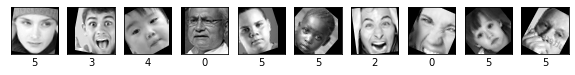

In [30]:

train_ds = train_ds.map(lambda x, y: (tf.numpy_function(augmentations.augment_image, [x], x.dtype), y),num_parallel_calls=AUTOTUNE) 

In [33]:
train_ds


In [ ]:
plt.rc('figure', facecolor='FFFFFF')
fig = plt.figure(figsize=(10, 50))

for i, (image, label) in enumerate(train_ds.take(10)): # DATASE HAVE TO BE UNBATCHED
    image = image.numpy()
    label = label.numpy()
    ax = fig.add_subplot(1,10, i+1)
    ax.imshow(image[:,:,0]/255, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(np.argmax(label))
plt.show()

In [ ]:
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(128).prefetch(AUTOTUNE)
test_ds = test_ds.batch(128).prefetch(AUTOTUNE)

In [ ]:
# labels = [np.argmax(y) for x, y in train_ds]
# neg, pos = np.bincount(labels)
# total = neg + pos

# # Scaling by total/2 helps keep the loss to a similar magnitude.
# # The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)


# CLASS_WEIGHTS = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

Show images

In [44]:
# for _ in range(5):
#     img, label = train_ds.take(1)
#     print(img.shape)   #  (1,256,256,3)
#     plt.imshow(img[0][:,:,0], cmap="gray")
#     plt.show()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

##### Build model

In [ ]:
# import necessary layers
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D

vgg_notop = tf.keras.applications.VGG16(
    include_top=False,
    weights=None,
    input_shape=INPUT_SHAPE,
)

print(vgg_notop.summary())
last_layer = vgg_notop.get_layer('block4_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu', name='fc6')(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu', name='fc7')(x)

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)

# model.build()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0001),
              metrics=['accuracy'])

model.summary()

In [42]:
model.summary()

Save model summary

In [ ]:
with open(summary_filepath, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

Compile model

In [45]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=0.0001),
              metrics=['accuracy'])

29/29 [==============================] - 3s 94ms/step - loss: 1.9932 - accuracy: 0.2410


[1.9932092428207397, 0.24101421236991882]

Pre-evaluate model

In [46]:
model.evaluate(test_ds)

Callbacks

In [47]:
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath=best_model_filepath)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)
csv_logger = tf.keras.callbacks.CSVLogger(filename=csv_logger_filepath)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=OUTPUT_DIR)


def schedule(epoch) -> float:
    if epoch >= 5:
        return 0.00005
    return 0.0005
# reduce_lr = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)


Epoch 1/300
225/225 [==============================] - 89s 390ms/step - loss: 1.8209 - accuracy: 0.2496 - val_loss: 1.8104 - val_accuracy: 0.2494 - lr: 0.0100
Epoch 2/300
225/225 [==============================] - 79s 350ms/step - loss: 1.8053 - accuracy: 0.2527 - val_loss: 1.7798 - val_accuracy: 0.2561 - lr: 0.0100
Epoch 3/300
225/225 [==============================] - 78s 344ms/step - loss: 1.7653 - accuracy: 0.2661 - val_loss: 1.7177 - val_accuracy: 0.2848 - lr: 0.0100
Epoch 4/300
225/225 [==============================] - 75s 332ms/step - loss: 1.7233 - accuracy: 0.2906 - val_loss: 1.6583 - val_accuracy: 0.3260 - lr: 0.0100
Epoch 5/300
225/225 [==============================] - 75s 331ms/step - loss: 1.6613 - accuracy: 0.3289 - val_loss: 1.6244 - val_accuracy: 0.3644 - lr: 0.0100
Epoch 6/300
225/225 [==============================] - 78s 343ms/step - loss: 1.5652 - accuracy: 0.3791 - val_loss: 1.4401 - val_accuracy: 0.4283 - lr: 0.0100
Epoch 7/300
225/225 [=========================

##### Training

In [48]:
history = model.fit(
        train_ds,
        epochs=MAX_EPOCHS,
        validation_data=val_ds,
        callbacks=[save_checkpoint, csv_logger, reduce_lr, early_stop],
        # class_weight=CLASS_WEIGHTS,
        workers=10,
        # use_multiprocessing=True
    )

29/29 [==============================] - 3s 84ms/step - loss: 1.0734 - accuracy: 0.6606


[1.0733801126480103, 0.6606296896934509]

Evaluate model

In [ ]:
# uncomment to load best model
# model=tf.keras.models.load_model(best_model_filepath)

model.evaluate(test_ds)

### VISUALIZATION

Loss and accuracy history

29/29 [==============================] - 4s 146ms/step


<Figure size 432x288 with 0 Axes>

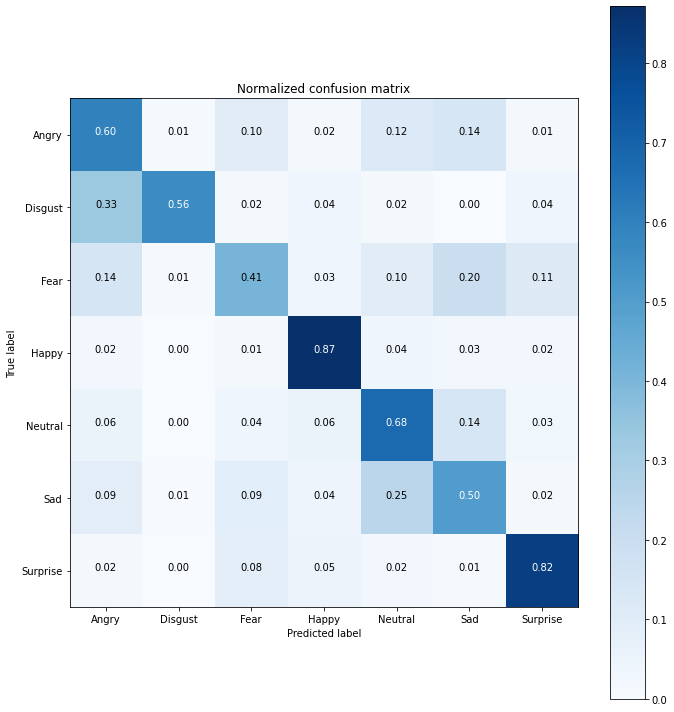

<Figure size 432x288 with 0 Axes>

In [54]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig(history_filepath, facecolor='white', bbox_inches='tight')
plt.show()

Trues and predictions

In [52]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(test_ds)
preds = [np.argmax(probas) for probas in predictions]
trues = np.concatenate([y for x, y in test_ds], axis=0)
trues = [np.argmax(t) for t in trues]
class_names = class_names

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(trues, preds)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()
plt.savefig(confusion_matrix_norm_filepath, facecolor='white', bbox_inches='tight')

              precision    recall  f1-score   support

       Angry       0.59      0.60      0.59       491
     Disgust       0.67      0.56      0.61        55
        Fear       0.55      0.41      0.47       528
       Happy       0.87      0.87      0.87       879
     Neutral       0.59      0.68      0.63       626
         Sad       0.51      0.50      0.51       594
    Surprise       0.74      0.82      0.78       416

    accuracy                           0.66      3589
   macro avg       0.65      0.63      0.64      3589
weighted avg       0.66      0.66      0.66      3589



Classification report

<Figure size 720x720 with 0 Axes>

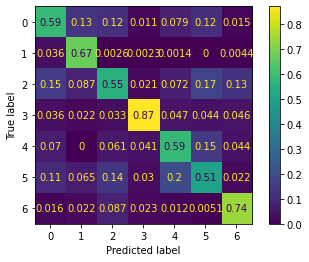

In [53]:
cr=classification_report(trues,preds,target_names=class_names)
cm = np.array2string(confusion_matrix(trues, preds))
with open(report_filepath, 'w') as f:
    f.write(f'Title\n\nClassification Report\n\n{cr}\n\nConfusion Matrix\n\n{cm}\n')

print(cr)

Confusion matrix

In [ ]:
cm=confusion_matrix(trues, preds, normalize='pred')
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.savefig(confusion_matrix_filepath, facecolor='white', bbox_inches='tight')